# Glasses product color classification

The goal of your project is to create a robust classifier, to collect data and prepare custom dataset. 

---------------

We will create a system that will recognize one of the 15 colors present in their products

* Classes :  ['black','blue','brown','burgundy','clear','gold','green','grey','orange','pink','purple','rainbow','red', 'silver', 'yellow']
 

This project consists of the following activities :


1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Preparation
2. Phase 2 : Training
    * Research about neural networks
    * Compose neural network architectures
    * Ping Pong phase with Dataset labelers
    * Generate syntethic data if needed
    * Fine tunning of our model
3. Phase 3 : Deployment
    * Analysis and benchmark Precision/Recall
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from stakeholder


**Import modules**

In [1]:
from sklearn.datasets import load_files  
import numpy as np
import pandas as pd
from keras.utils import np_utils
import cv2

import keras, os
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, MaxPool2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.constraints import max_norm
from numpy import expand_dims
from io import BytesIO
from PIL import Image
from tabulate import tabulate

import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

**Mount Drive and unzip images into Colab**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') # gdrive sync

Mounted at /content/gdrive


In [3]:
!unzip gdrive/MyDrive/Ryaktive/Glasses_Lens_Color/Train_Val_Glasses_Lens_Color.zip -d content/ #personal path

Archive:  gdrive/MyDrive/Ryaktive/Glasses_Lens_Color/Train_Val_Glasses_Lens_Color.zip
   creating: content/Train_Val_Glasses_Lens_Color/Black/
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-01.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-03.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-04.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-05.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-07.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-08.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-09.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-100.jfif  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-1000.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-1001.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-1002.jpg  
  inflating: content/Train_Val_Glasses_Lens_Color/Black/black-1003.j

In [4]:
!unzip gdrive/MyDrive/Ryaktive/Glasses_Lens_Color/Test_Val_Glasses_Lens_Color.zip -d content/ #personal path

Archive:  gdrive/MyDrive/Ryaktive/Glasses_Lens_Color/Test_Val_Glasses_Lens_Color.zip
   creating: content/Test_Val_Glasses_Lens_Color/Black/
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-02.jpg  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-06.jpg  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-10.jpeg  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-102.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-106.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-110.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-114.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-118.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-122.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-126.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-130.jfif  
  inflating: content/Test_Val_Glasses_Lens_Color/Black/black-134.jfif  


# Read files and preprocess the images

**Create functions for image processing**

In [5]:
def load_image(path):
  image = cv2.imread(path).astype('float32')
  image = preprocess_input(cv2.resize(image, dsize=(224,224)))
  return image

def image_process(files):
  vector = []
  for file in files:
    vector.append(load_image(file))
  return np.array(vector)

**Load Train and Validation datasets**

In [6]:
def load_dataset(path):
    data = load_files(path)
    color_files = np.array(data['filenames'])
    color_targets = np_utils.to_categorical(np.array(data['target']), 15)
    color_names = data['target_names']
    return color_files, color_targets, color_names

# load whole dataset
train_files, train_targets, train_names = load_dataset('content/Train_Val_Glasses_Lens_Color/')
val_files, val_targets, val_names = load_dataset('content/Test_Val_Glasses_Lens_Color/')

In [7]:
print(tabulate([['Train', len(train_files), train_targets.shape, len(train_names)],
                ['Validation', len(val_files), val_targets.shape, len(val_names)], 
                ], headers=['Dataset', 'No. of files', 'Target shape', 'No. of classes']))

Dataset       No. of files  Target shape      No. of classes
----------  --------------  --------------  ----------------
Train                 4136  (4136, 15)                    15
Validation             695  (695, 15)                     15


**Preprocess the images**

In [8]:
#train dataset
train_X = image_process(train_files)
train_X.shape

(4136, 224, 224, 3)

In [9]:
#validation dataset
val_X = image_process(val_files)
val_X.shape

(695, 224, 224, 3)

## Visualize the train dataset

In [10]:
class_names_processed = list(map(lambda x : x, train_names))

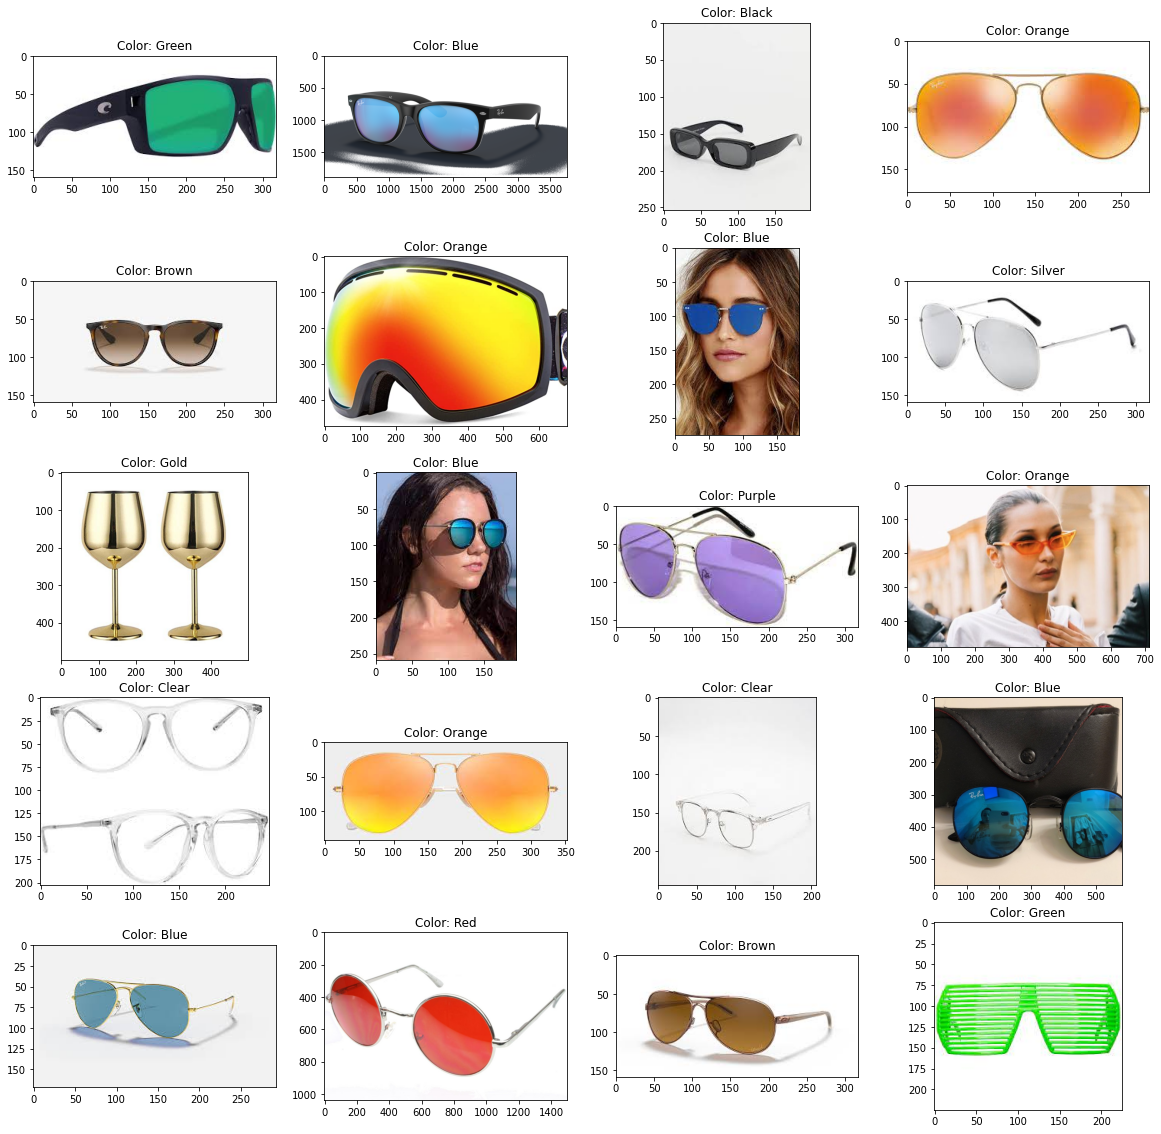

In [11]:
# add graph
fig = plt.figure(figsize=(20,20))

rows = 5
columns = 4

for i in range(rows*columns):
    ax1 = fig.add_subplot(rows, columns,(i+1)) 
    # show the image
    image = cv2.imread(train_files[i])
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax1.imshow(img_rgb, cmap='gray')

    title = "Color: "+class_names_processed[np.argmax(train_targets[i])]
    plt.title(title)

## Generator

In [12]:
def generator(X_samples, Y_samples, batch_size=50):
    """
    Lazy batch train/validation generator for memory efficiency
    """
    while True:
      for offset in range(0, len(X_samples), batch_size):
        batch_samplesX = X_samples[offset:offset+batch_size]
        batch_samplesY = Y_samples[offset:offset+batch_size]
        new_batch = []
        for image in batch_samplesX:
          image_resized = cv2.resize(image, dsize=(224,224))
          new_batch.append(image_resized)
        X_train = np.array(new_batch)
        y_train = batch_samplesY
        yield X_train, y_train
train_generator = generator(train_X, train_targets, batch_size=50)
test_generator =  generator(val_X, val_targets, batch_size=50)

# Model Architecture

In [13]:
from keras.applications.densenet import DenseNet169

model = DenseNet169(include_top=False, input_shape = (224,224,3), weights='imagenet')

layer = model.get_layer('conv5_block29_2_conv')

layer_1 = Dense(512, activation='relu')(layer.output)
pool = GlobalAveragePooling2D()(layer_1)
layer_2 = Dense(64, activation='relu')(pool)
batch_norm = BatchNormalization()(layer_2)
drop = Dropout(0.4)(batch_norm)
output = Dense(15, activation='softmax')(drop)

model = Model(inputs = model.inputs, outputs = output)

51888128/51877672 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Define Loss Function, Optimizer

In [15]:
optimizer = keras.optimizers.Adamax(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Define Augmentation

In [16]:
datagen = ImageDataGenerator(rotation_range=10, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             shear_range=0.15, 
                             zoom_range=0.15, 
                             channel_shift_range=10., 
                             horizontal_flip=True)

datagen.fit(train_X)

## Train the model

In [17]:
from __future__ import generator_stop
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.pt', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# model fit code
history = model.fit(datagen.flow(train_X, train_targets),
          validation_data = test_generator,
          steps_per_epoch = len(train_X)/50,
          validation_steps = len(val_X)/50,
          epochs=50,
          callbacks=[anne,checkpoint],
          batch_size = 50)

Epoch 1/50
82/82 [==============================] - 148s 760ms/step - loss: 1.9174 - accuracy: 0.4519 - val_loss: 2.4812 - val_accuracy: 0.7180

Epoch 00001: val_accuracy improved from -inf to 0.71799, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
Epoch 2/50
82/82 [==============================] - 44s 526ms/step - loss: 0.5402 - accuracy: 0.8871 - val_loss: 2.1048 - val_accuracy: 0.8158

Epoch 00002: val_accuracy improved from 0.71799 to 0.81583, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
Epoch 3/50
82/82 [==============================] - 43s 522ms/step - loss: 0.3872 - accuracy: 0.9087 - val_loss: 1.5744 - val_accuracy: 0.9453

Epoch 00003: val_accuracy improved from 0.81583 to 0.94532, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
Epoch 4/50
82/82 [==============================] - 44s 528ms/step - loss: 0.2558 - accuracy: 0.9455 - val_loss: 1.0245 - val_accura

## Load best model

In [18]:
from keras.models import load_model

best_model = load_model('best_model.pt')

* Save best model to zip

In [19]:
!zip -r content/best_model_lens_color.zip  best_model.pt

  adding: best_model.pt/ (stored 0%)
  adding: best_model.pt/keras_metadata.pb (deflated 96%)
  adding: best_model.pt/variables/ (stored 0%)
  adding: best_model.pt/variables/variables.index (deflated 81%)
  adding: best_model.pt/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: best_model.pt/saved_model.pb (deflated 93%)
  adding: best_model.pt/assets/ (stored 0%)


In [20]:
!zip -r gdrive/MyDrive/Ryaktive/Glasses_Lens_Color/best_model_lens_color.zip  best_model.pt

updating: best_model.pt/ (stored 0%)
updating: best_model.pt/keras_metadata.pb (deflated 96%)
updating: best_model.pt/variables/ (stored 0%)
updating: best_model.pt/variables/variables.index (deflated 81%)
updating: best_model.pt/variables/variables.data-00000-of-00001 (deflated 18%)
updating: best_model.pt/saved_model.pb (deflated 93%)
updating: best_model.pt/assets/ (stored 0%)


# Model Evaluation

In [21]:
# validation dataset

score = best_model.evaluate(val_X, val_targets)

print('Test accuracy: ', score[1]*100,'%')

22/22 [==============================] - 18s 202ms/step - loss: 0.0866 - accuracy: 0.9842
Test accuracy:  98.41726422309875 %


## Confusion Matrix

In [22]:
# Predicted values for validation dataset

predictions = best_model.predict(val_X)
val_predictions = np.argmax(predictions, axis=-1)

In [23]:
# True values for validation dataset

val_targets_class = np.argmax(val_targets, axis=-1)

**Visualize the confusion matrix**

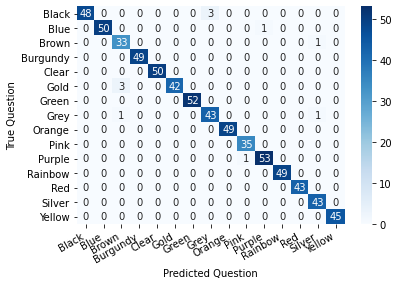

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names=['black','blue','brown','burgundy','clear','gold','green','grey','orange','pink','purple','rainbow','red', 'silver', 'yellow']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Question')
  plt.xlabel('Predicted Question');
cm = confusion_matrix(val_targets_class, val_predictions)
df_cm = pd.DataFrame(cm, index=train_names, columns=val_names)
show_confusion_matrix(df_cm)

## Precision and Recall

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#print evaluation metrics 
print(classification_report(val_targets_class,val_predictions))
confusion_matrix(val_targets_class,val_predictions)
print("Accuracy:",accuracy_score(val_targets_class,val_predictions))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        51
           1       1.00      0.98      0.99        51
           2       0.89      0.97      0.93        34
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        50
           5       1.00      0.93      0.97        45
           6       1.00      1.00      1.00        52
           7       0.93      0.96      0.95        45
           8       1.00      1.00      1.00        49
           9       0.97      1.00      0.99        35
          10       0.98      0.98      0.98        54
          11       1.00      1.00      1.00        49
          12       1.00      1.00      1.00        43
          13       0.96      1.00      0.98        43
          14       1.00      1.00      1.00        45

    accuracy                           0.98       695
   macro avg       0.98      0.98      0.98       695
weighted avg       0.98   

## Visualize Model Training History

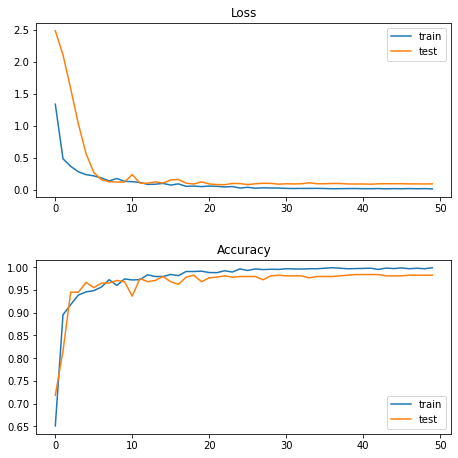

In [26]:
figure, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,7))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
figure.tight_layout(pad=3.0)
plt.show()

# Predictions

 **Define functions for prediction**

In [27]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    prediction = best_model.predict(image)
    predicted_class = np.argmax(prediction)
    return class_names_processed[predicted_class]

In [28]:
import urllib.request
import cv2
from keras.applications.imagenet_utils import preprocess_input

def url_to_image_(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_resized = preprocess_input(cv2.resize(image, dsize=(224,224)))
  return image_resized, image_

def predict_url(url):
  image_resized, image = url_to_image_(url)
  predicted_class = get_prediction(image_resized)
  plt.imshow(image)
  plt.title("Predicted : " + predicted_class)

## Testing

#### *Black Color images*

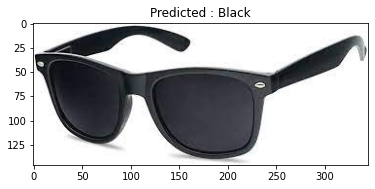

In [29]:
predict_url('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUWFRgVFRUYGRgYGRgYGhgYGBoYGBgYGhgaGhgYGBgcIS4lHB4rHxkYJjgnKy8xNTU1GiQ7QDszPy40NTEBDAwMDw8QGA8RGDEdGB0xMT80MTExMTE0PzQ/MT80NDQxNDQ0PzQ/PzE/MTExNDE0MTExMTExMTExMTExMTExMf/AABEIAJIBWQMBIgACEQEDEQH/xAAcAAEAAAcBAAAAAAAAAAAAAAAAAQIDBAUGBwj/xABEEAACAQICBQkFBQcEAQUBAAABAgADEQQSBQYhMUEHIjJRYXGBkaETQlJysWKCksHhFCMzQ6LR8FOywtKzFiRjk/EV/8QAFgEBAQEAAAAAAAAAAAAAAAAAAAEC/8QAFxEBAQEBAAAAAAAAAAAAAAAAABEBIf/aAAwDAQACEQMRAD8A7NERAREQERKGIxCIMzuqKOLEKPMwK8TRtM8puBoXVWNZhwpjZ+IzRtL8rmKe4oU0pDrPPf12SxK7ezAC5Nh2zC6R1twNC/tMTTBHANmbyW887aS1ixWIP77EVH7CxC/hGyY2WFd0x3K3gl2U0q1D1hQi+bG/pMDieWNz/DwijteqT6BR9ZykCVqNBmYKqszMbKqgszHqVRtJ7omJXQanK5jT0aWHX7rn/nKa8rWOG9cOfuP/AN5Q0PyYY6qAzqlBT/qNd/wLe3iQZsKcjrW24xb9lE2/8knF6x9HlixA6eGpN8rOn1vMzg+WOgbCrhqidZRlcDwOWYLSXJVi0BNNqdXsBKP5Ns/qmlaR0PUovkq03Rup1K37RfeO0RxOu8aN5Q9HVrAYgUyeFUGn/U3N9Zs1CurgMjKwO5lIIPiJ5VWjaXmAxlSi2ajUem3WjlfMDYfGIteo4nENDcp+MpWFcJiE4kjI9vnUZT4rOi6ua9YPFkIrmnVP8qrZWJ+wb5X7gb9gkVtcREBERAREQEREBERAREQEREBERAREQEREBEx2ktM0MOL1qqJ2E849yjbMHT19wrNlUVGHxBQB6kQNtiW2DxaVUDobg+BB6iOBlzARKVSqq7WIE17TetBokLSoPWJ4q1MKO8M4Y+C+MDZpgdNa14TCgmrVW/wqczTmmmtOaXxRyU6RpIdnTpjZ28/+812rqtiFOZ8PiMS/2BZPF75m+6F75YNl07ytVXuuEpZQPfcZmt1gbhOd6T03iMQ2avVdyeBY2HcJkMTRxvQfDVaNPbdBQdE72JXnd5Jmvki9r7erj5S4iF5CTZZE2G8gd8USgSoqzM6M1Xxte3ssLVYH3ihRO/O9lPnN00HySYhmDYqqtJOKUznqEdWYjKvfzoqRqGq+rGIxtTJRWyrbPVYHIgPX8TW3KNp7Btnd9V9VMPgVtSS9Qjn1nsXfx91fsiw7zczJ6K0XSw1JaNBAiLuA4nizE7WY8Sdpl/MtEREBLTHYClWQpVRXU+6wBHeOo9ol3EDlmsvJcNr4Jtu/2Ln0Rz9G85zLG6PekxSqjIw3qwIM9QTG6Y0LQxKZK9MOOB3MvarDaJajzPlMp1Be1+G39Z1DTXJXVUlsLUV1+CocrD7wBDekqarcmD+0FTG5CqG60VObORu9o1rZPsi9+Oy4Ijd9Q2rHAYdq5ZnZL3a5YoWJplidpOTJtO3r2zY5ACRkUiIgIiICIiAiIgIiICIiAiJRr1lQZnYKBxJtArSUm20zQ9YOU7C0LpSvWcbOb0Qe0zmWnNeMZiiQahp0/gpkjzbefSWJXYtPa8YPC3DVM7/AnOb9JzfTnKViq91ogUE6xtcjv3CaCv8Ah4mXFJLwlXqO7tmdizHezEsT4mbPorCtbNlNhvIGwd5kNSNW2xVWxutNLF3G/sRftHb3AE9V+w4nR6igUpqFCrdABuIG7x2g9d4pGG1PrWut9hHqP0vNsnN1LKBkNj7ajlt2uLD8p0iRcee+VOg//wDTrC7MGWkyrcmy+zVSAOrMrGaWaC/CPKdl5RNINgsfRxIQOlagabC+Vr0nLXVrGxtUGw7DbxHPNZ9LpjMUKiU2QFEQ5suZ2Ba7vl2XsQOPR3y5TWETR4ILZQFG9jZVHex2SCUFXo1UB+y5+okukK+d7e6t1UcFA4953k9stSJRmcNpPEp/DxbjsFe3oWEyn/qrGEWrBK6cRVpJUB72IP1moydDbaNh6xsPnA2yjpTAOR7fAqhvtNB3RT2FFYDysZ0fVTTuiksKFClTb4go9p4s3O/qM4mMS3E5vmF/6t/rJ1dTvBX1H9x6xB6mwukKT9F1JPDcfI7ZeTzFgNMYil0KhK9R56+IO0ek3HQ3KVVSwqBrdnPX8J2jwMkK7ZE07RGvuGrWBYX+ydvih2j1mz4bHU36Lqey9j5HbIq6iIgIiICIlriNIUU6dWmnzOq/UwLqJgK+uOATpYql91s3+28sKvKLo5f5+b5Ub8xA26JpDcp2AG5qh7k/WQHKdgOuoO9P1gbxE0tOUzR531CO8AfnLuhr7gG3V18x/eBtMTDUdZsI/RrKfH+0vE0pRO6ovnb6wL2JRSup3Mp7mBlaAiIgIiUq1ZUUs5AA3kmwgVZQxOIRFzOwUDiTaaNrPyk0KF1pfvH7N3fOR6f1qxOKYmo5C8EB2SxK6nrLypUaV0w6+0fr90f54zlemtZ8Ti2Jq1Dl+Bbhe49fjMKqSoqQlQEqKsqJSldEEqqSU5lNE4BqtRaVNczuwVR29ZPAAAkngAZV0RoaviWy0KTvtsWAsi/M5so8517UjU0YMGrVKvXYZbr0aanaVQnaSSBc7Nw2dcMZ7V7Q6YWgtFNttrNxdz0mP5DgABwmViJFatorRTCu2ZCEVsykjYxUnLY8d4PhNpiIGL03oWhi6RpV0DKdoO5ka1g6NvVhfePpPPesGgnwOLNBzmAKsj2tnpsTla3A3BUjrU8LT0xOZ8s+ic1ClilHOovkY/8Ax1LD0cJ+Iy4OIuvOYdrfWSOJdYlf3p+1zvMSjUWXEUpMJDLIiUREqLKcnUwKqdm+XCNff5j8xLZZUQyQVssvcLp/E4dhkcsuzmOcy+u4yxUyXFdG8DomiuVKogs9Et2B7r4Zto85lTyrsejhTfrLrb/dOS4RplaMkK3PSHKhjdmSnRQHrDMfrYesw2K1+0jUv/7jIPsIq+trzX8c3R8ZTTKql36I2WG9j1CUXuI0riqp5+IrPfgXY+l5avQA6bKD9o5m8hcy0fFO2y+VfgXYLdvFvGQUQLq9McSflX+5ELXTgrHvYD6Ay3EjliEXBxK/Afx/pH7Wvwf1/pKAWMsQXC4xeKH8QP5Sf9opnep/CD+ctMkZYgvAlA8Ev2rb1tLimnFHcfJUcDyVrTGBZME4ypGbTH4lOjiKg7CVcf1KT6y/w2tmOS1qqEdqMp81b8prtOuw3m/fv85cJUDbvKSK3DC8pGJXpU8w+y4YnwdfzmVw/Kgvvo6fNSL/APjYzRcDgXqvkpoXO87VVVF7ZndiFUeNzwBl1jNBuiFw+HqqoLP+z11qlFAuWZdhyjiQDbfu2ycOt2xXKdSprmLo99yojZvEFtnjOc6ya7YjEszZiik2sDty+6vUO2wF/WY/SlO6jvmOShzfEfnAoC52+p2kyolOXS0QBtmw6F1QxeJsaVBgh99+YneC21h8oMo1pKUr0qJJCqCzHYFUFmPYFG0zreh+SqmtmxNZnPwU+YvcWPOPhlm9aK0Jh8OLUKKU+sqOcfmc7W8TJSONaG5PMdXszIKCH3qux7dlMc6/Y2Wb/oXk1wlGzVc2IcfHzad+ymu8fMWm8RIqlRpKihUUKo2BVAVQOwDYJViICIiAiIgJjtO6OXE4erQbdVpsl+okc0+BsfCZGIHlDFqRkLCzISjjqZTtB/q8pJXp7Zt/KZon2OMxCgc2qFxKbPiuKg784c/eE1cjMgbrHruM1iLErIBZXZJIElEoEiJMBIZYEwlQSQCTiBUUyR9q2/zYZVSU6a3JH2iPMyamqeD3zL0pt2p+j8I9WhTfDo+csGLXJPNJU77DcPOb5j+TrBODkVqTcGR2I8UYlbdwElWOIYsbR3fnLHSLc5E4AA+LE/8AUTZda9B1MJXNFyG5oZHAIDoSRe3Agggi5ts4ETWtJdND1hfQsD9RKRBBKqiU1EqKJRMBJhIWkyiBMJC0ngLAlyyIWTFYUQIASYLI5ZMBAlCxlO9d4/y0qWgQL/RmkalIh6LsjEWNrEEXvlZSCCL9cyukNasVWQ03dApBDZEVWYEWILG5APZaa7hztYdRv5gH6kzL6D0Y2JrJRBy5ztbfYcTbjM7mDD41eZ4j12CbbqrycVsQoqYgtQQ2KqV/esNtzlPQG7pXO/YNhPT9D6rYXD2NOkC4/mPznv1hj0fu2EzsUjXNDamYLDWKUQzj36nPe/WL7F+6BNjiJFIiICIiAiIgIiICIiAiIgc65X9FZqFPFAXNB8r9tKrZT5ME8CZxvBrbPTPum47v8t5z09pLBJWpVKLi6VEZG7mBBt27Z5j0thnw1cq459JjTccGK8R2MpBHZaXBTqU5SKzIugIBG0EXB7DLd0mkWmWQyyuySUiBIBJlEASoBAmRZDCDn/ePoTJ0WT6KS7d9/U/rJo3jUKiWxlEfCST3Khna5zjkx0dznrEbFXKO9jc+g9Z0eTVaDytaJ9phkxCjnYdrnZt9k9lceDZG7lM4rpVOYrfC1vA/qBPUGNwq1ab0nF0qKyMOtWBBHkZ5x0lo56bVcO/TRmQnrK9F+wMMrDsYRiMTTNwDKiy3wR2EdX+f3lyJcEwlRRJFlQSiIEiBCyfLAhaAJMIAgQkQJMBIiAAkypCiVFgUU6bfKn1abvyaUM2MB+BGbzGX6sPKaSo/eN8ifV50rkooc+s/wqqfiN/+MmjpsREypERAREQEREBERAREQEREBERATk/LDqzmAxqLssqVrcADanU8L5SeorwBnWJRr0VdWR1DKwKspFwVIsQR1EQPLmBrZD7N929Tw27R4G/nLqpTmf171NbBt7zYVmPs6tsxpFv5dTrF9x499wdVTEMllqbV91wcwI7+P1E1monZZTYS4axFwQR1iUysopgSNpMFlQJAlLWBPUDMlq3hSzbBew//AD1tMTX3hfE9w/X6TqXJpoLNlZl5qkOx6z/LT/kf1k3R0LVzR3sKCJazHnN3nh4Cw8JloiZUnKuVnQuV0xiDY9qVXsYfw3PeLoT2IJ1WWWlcAmIpPRqC6VFKnrF9xB4EGxB6wIHl3GJkqZvdbb59L12+MrqJldYNDPSd8PUHPpnmm1g4911+yw8js3gzDYKpsyHeN3aN3pu8JrEXAEnEKJPaUQEmBkBIwJpESUScQI2kVkBJhAmEnWSLKggUU/iP8qD6n8513kroWw9R/jqW/Co/vOQ4ba7n7YA8FUfW87rqLhfZ4KkCLFgXP3iSPS0mjYoiJlSIiAiIgIiICIiAiIgIiICIiAiIgWGPpllKlFdGBDIwDKwO8EHYROSay6ihSz4S6A3LYepzqZ+Rzu7m8GG6dqlKpRU7wDA8sYnCNTcqyvSfipBKntF9tvxCSiq/FQ3ap/L9J6V0jq5hqy5alNWHUwBHrumn6T5J8M+2k70z1Xzr5Nt9ZajjoxPWj+UgcUx2Ktu/b9N06FiOSmqu6oGHybf90uNGakUKbA11qvb3RZFPfa7eREUjV9TdV6uLq2AOQEF3I5qj8z1Cd+0dgEoU1p0xZV8yeJJ4mWGicTh0QU6SrTUblAsP1PbMwrg7jJqp4iICIiBqGvuq37XTD0wPb0wcnD2i7zTY+oPA9QJnCMfhWDFgCrKSGUixVgbG4O7aLEdfjPU00bXfUhcTfEULLXtzlOxKwAsM3wuBsDcdx4FbmjiWHr5uxhvH9uyVxJMdo9lcqwanUQ5SrAgqd+Vl3gbb3F9/EG4opibELUGRuB3qw6wRst2i4lqLvLJ8sgp4jaPSRvKFpESBkQYERJgZLeLwKt5B6gALHcASe4SQNLOpV9qcidC92brtwHZAyWhMKzlEA51RwO5qjbPVhPReGohEVF3KqqO4Cw+k5ZyZ6EL1v2hhzKVwvU1Qi3jlU37ys6zM6YRESKREQEREBERAREQEREBERAREQEREBERAREQEptTU7wDKkQLN9H0z7o8JPSwoXcZcxAREQEREBJGcDfJ5I6A74Gv6x6vYTGL+9FqgFlqpYOvZfcw7GuJy3TeouJo3yBcTTvfmAFu9qJOYNwuhJ7RO01MApltU0Kh4kQPNr4QKxAL02G9ekB3q1mXuOYyGeou5kfvOQ+TZZ6Bx2qVKrsez9WdQxHcTtHhMFieTKg3RLJ8rX9GvLRx4YipxosflN/oDI/tL/wCi/kf7TplbkpPu1fxID9CJanktqD31/wDrH/aWo542Jf8A07fM4X6yAeqd2Qd12PpsnSKfJwV6TuflVV+t5k8HqVh0tnoVHt8dRgPJMsUcmTBlrB3ZidgXcCerKN83rVjUKvWIZ0NClvJcWdh1Kh2jva3jOk6Kw9Cj/CwyUz1qgDHvbefEzNU64PCSkU9HYFKNNaVNcqKLAfUk8Sd95dxEikREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBJYiBIRJhEQJ4iICIiAiIgIiICIiAiIgIiICIiB//9k=')

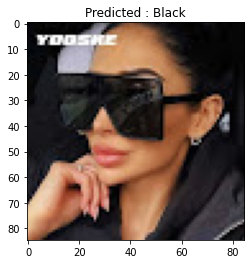

In [30]:
predict_url('https://lh3.googleusercontent.com/b43s-Y1WEcmpwcfvDOKc6exu5HRumA4D9SPzCDPWkujezU4V7tRUyeszYqZ6azpPnucY6g=s85')

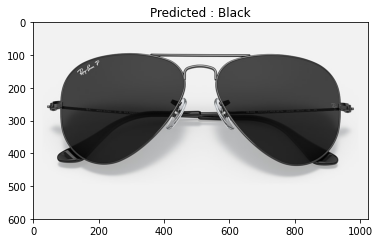

In [31]:
predict_url('https://images.ray-ban.com/is/image/RayBan/8056597328111__STD__shad__cfr.png?impolicy=RB_Product&width=1024&bgc=%23f2f2f2')

#### *Blue Color images*

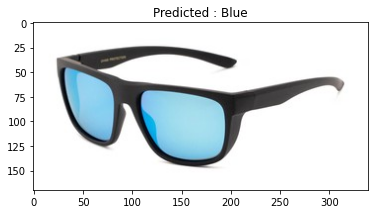

In [32]:
predict_url('https://www.sunglasswarehouse.com/tn_images--D--SW-Charles-Angle-BlackBlue---JPG_w340_h175.jpg')

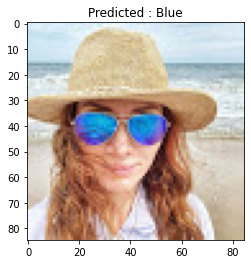

In [33]:
predict_url('https://lh3.googleusercontent.com/olmtKPHOWH5cNBbj7xzDjDriVVJt6F7HHCaUGcemp9tP4A8dC2M2L-fwkVhMi1tj6YOryg=s85')

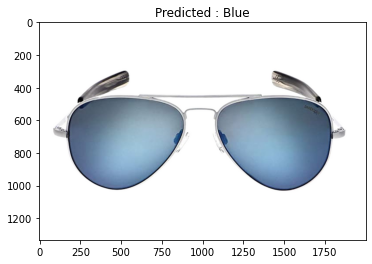

In [34]:
predict_url('https://media.gq.com/photos/606f2fae7b6ac30aec487acb/master/w_2000,h_1333,c_limit/Randolph-Engineering-Concorde-classic-aviator-sunglasses.jpg')

#### *Brown Color images*

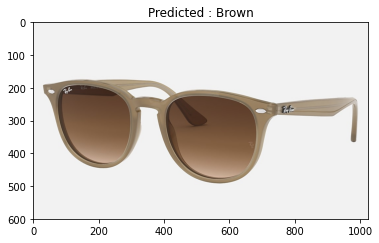

In [35]:
predict_url('https://images.ray-ban.com/is/image/RayBan/8053672602456__002.png?impolicy=RB_Product&width=1024&bgc=%23f2f2f2')

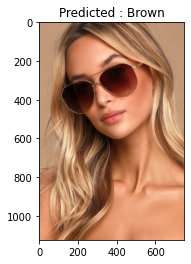

In [36]:
predict_url('https://www.lulus.com/images/product/xlarge/5625696_1166491.jpg?w=375&hdpi=1')

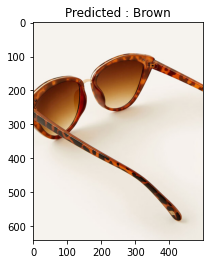

In [37]:
predict_url('https://www.monsoonlondon.com/dw/image/v2/BDLV_PRD/on/demandware.static/-/Sites-monsoon-master-catalog/default/dw0f05ee89/images/large/02_15157405_3.jpg?sw=500&sh=640&sm=cut')

#### *Burgundy Color images*

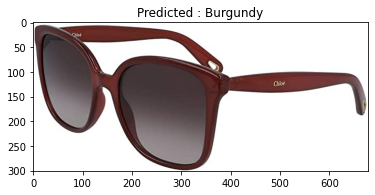

In [38]:
predict_url('https://images-na.ssl-images-amazon.com/images/I/41b1BXGbChL._AC_UX679_.jpg')

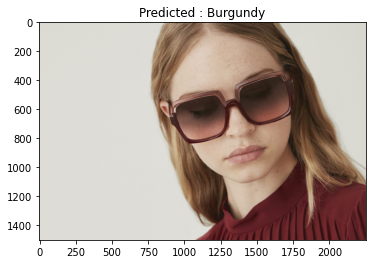

In [39]:
predict_url('https://gigistudios.com/wp-content/uploads/2020/08/6506-6-vivienne-squared-burgundy-sunglasses-by-gigi-studios-1.jpg')

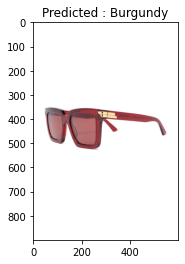

In [40]:
predict_url('https://cdn.shopify.com/s/files/1/2976/1390/products/Bottega-Veneta-BV1005S003-Side_800x.png?v=1604996906')

#### *Clear images*

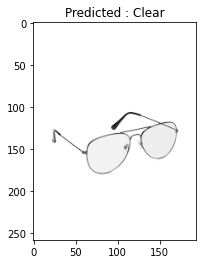

In [41]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTML_b4fkIOX1NgbSptco1FxQkQl1iPBDuXiNlly4bY8ILl4OsUiPNk3HwOjiIcasN6ldw&usqp=CAU')

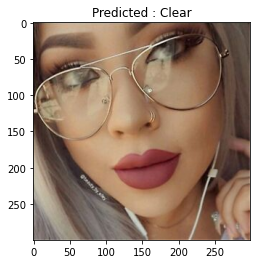

In [42]:
predict_url('https://i.ebayimg.com/images/g/p14AAOSwElxbzdUP/s-l300.jpg')

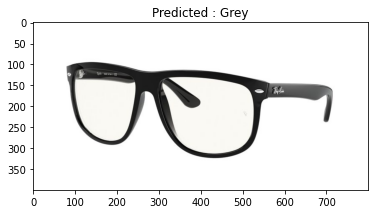

In [43]:
predict_url('https://cdn.staticans.com/image/tr:h-400,w-800,cm-pad_resize/data/sunglass-hut-sa/10July2020/8056597366878_030A.jpg')

#### *Gold Color images*

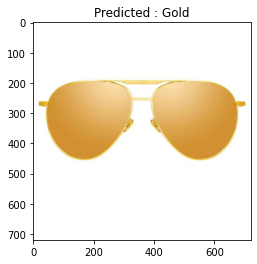

In [44]:
predict_url('https://cdn.shopify.com/s/files/1/0054/0262/4088/products/LFL999C2SUN_2_35d18bf6-eaa9-4c89-821a-3de3cb46b07f_720x.jpg?v=1572618782')

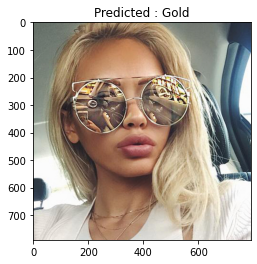

In [45]:
predict_url('https://d2a2wjuuf1c30f.cloudfront.net/product_photos/54044417/BTA020_20(5)_original.jpg')

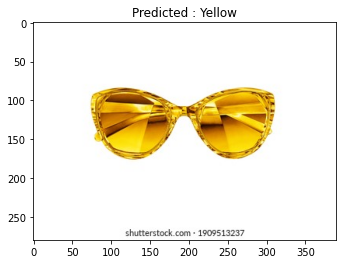

In [46]:
predict_url('https://image.shutterstock.com/image-photo/golden-sunglasses-white-background-isolated-260nw-1909513237.jpg')

#### *Green Color images*

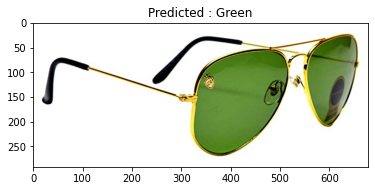

In [47]:
predict_url('https://images-na.ssl-images-amazon.com/images/I/51XBkEcqRFL._UX679_.jpg')

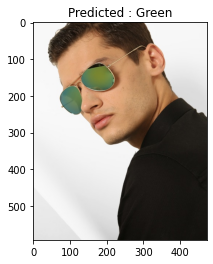

In [48]:
predict_url('https://assets.ajio.com/medias/sys_master/root/h22/h01/10942169939998/-473Wx593H-460168891-green-MODEL.jpg')

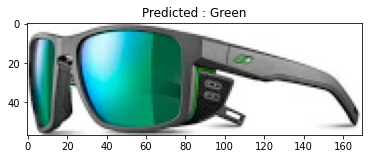

In [49]:
predict_url('https://lh3.googleusercontent.com/A8d_s1b-H6_Ln5-Bscu777z11k965C8coUfg-uoUQzQMOVgtBrpCeKnWrFMGfyBSU5ghjA=s170')

#### *Grey Color images*

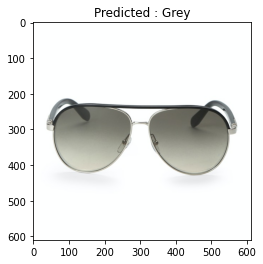

In [50]:
predict_url('https://the-collective.imgix.net/img/app/product/2/287221-3614439.jpg?w=610&auto=format')

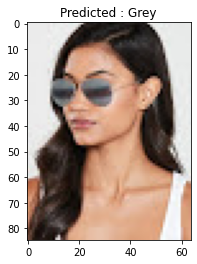

In [51]:
predict_url('https://lh3.googleusercontent.com/Z5xdkKUugLTDotMaMqClTa1MfT6OlbkbeWhqcLxWdDlPLkjKyz6N7M6onqkMRFFVoVLg5C0=s85')

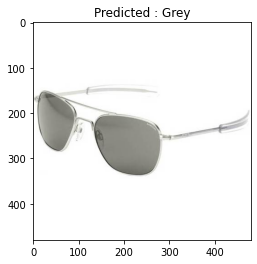

In [52]:
predict_url('https://cdn.shopify.com/s/files/1/2773/1296/files/randolph-aviator-55mm-matte-chrome-bayonet-wgrey-glass-af085-sunglasses-randolph-engineering-451959_540x_909c0950-ac1c-417b-aab3-8d9197708bf7_large.jpg?v=1573152535')

#### *Orange Color images*

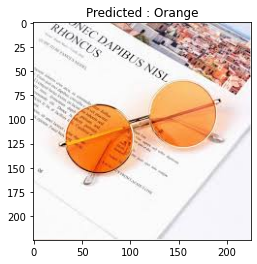

In [53]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTIL3cY1V34po7IuGKzfZdoEpfRIfQIk_Qtkg&usqp=CAU')

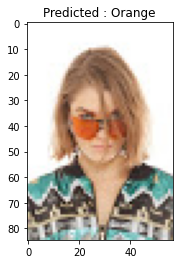

In [54]:
predict_url('https://lh3.googleusercontent.com/oapZwkY93ys_cKhadoj_e3aZBQ4akiGnS2JF5w8oViw0Xy7ijdRaxcUJKXaw6qm54GAm=s85')

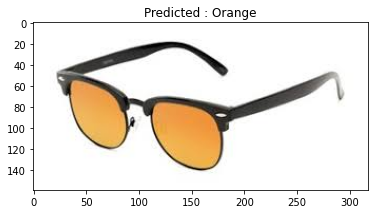

In [55]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3bl_eeGD7eOqUUoR87Lv2R_F57s84-JZFrA&usqp=CAU')

#### *Pink Color images*

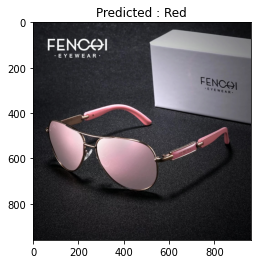

In [56]:
predict_url('https://ae01.alicdn.com/kf/HTB10YajoL5TBuNjSspcq6znGFXaf/FENCHI-2021-Pink-Sunglasses-Women-Polarized-Sunglasess-2020-Driving-Pilot-sun-glasses-Men-ladies-oculos-de.jpg_Q90.jpg_.webp')

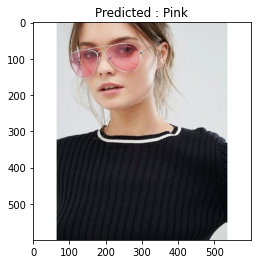

In [57]:
predict_url('https://i.pinimg.com/originals/25/44/89/2544898b635235ed062424c1fca8986c.jpg')

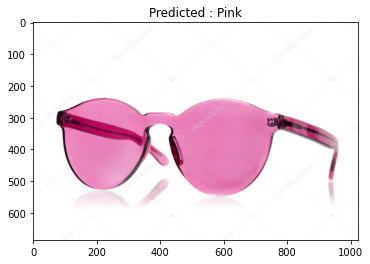

In [58]:
predict_url('https://static5.depositphotos.com/1001686/393/i/950/depositphotos_3933126-stock-photo-pink-sunglasses-isolated-on-white.jpg')

#### *Purple Color images*

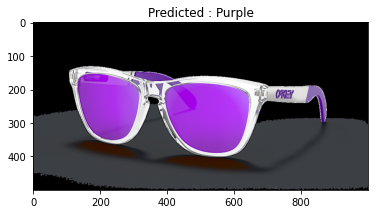

In [59]:
predict_url('https://assets.sunglasshut.com/is/image/LuxotticaRetail/888392404701__STD__shad__qt.png?impolicy=SGH_bgtransparent&width=1000')

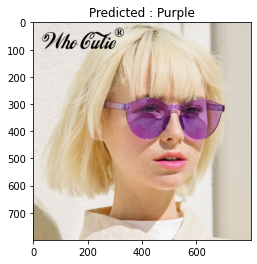

In [60]:
predict_url('https://ae01.alicdn.com/kf/Hb28ce6b249254ae3958af6d9e2bf2190c/WHO-CUTIE-2018-Purple-Round-Frameless-Sunglasses-Men-Women-Brand-Designer-Vintage-One-Piece-Transparent-Sun.jpg')

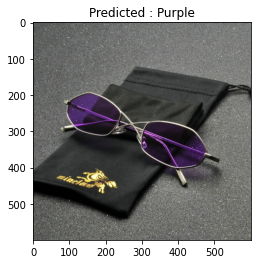

In [61]:
predict_url('https://canary.contestimg.wish.com/api/webimage/5c43dd0f0540ac140a7e9dd4-large.jpg?cache_buster=8ab06c0e895a452cf032e4d0e2fef186')

#### *Rainbow Color images*

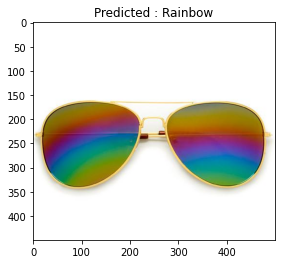

In [62]:
predict_url('http://cdn.shopify.com/s/files/1/0883/8564/products/avirm2_copy_600x.jpg?v=1573249829')

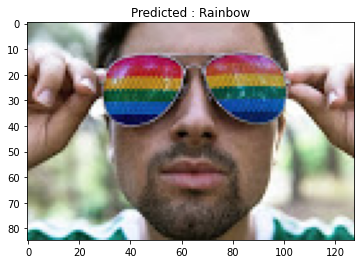

In [63]:
predict_url('https://lh3.googleusercontent.com/IEkqRJIeCtcb0zqZYtwcKk-wPAQK7RPj2GVcp1hsD6FcPkVtgZGuf_kJ-d5ERPQM4dAO7UI=s128')

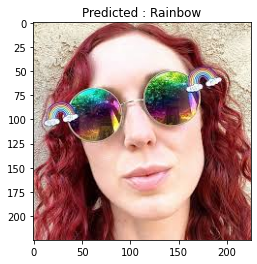

In [64]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQGOblYqv-lOl-jNzD1pwt4DEW6rEzytZWfeQ&usqp=CAU')

#### *Red Color images*

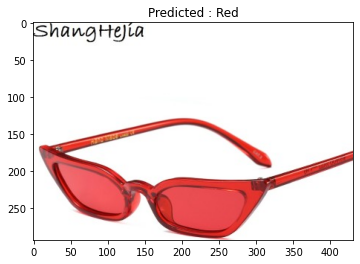

In [65]:
predict_url('https://res.cloudinary.com/webstore/image/fetch/w_450,c_limit,c_fit,f_auto,e_trim/https%3A%2F%2Fae01.alicdn.com%2Fkf%2FHTB1V7ler1GSBuNjSspbq6AiipXau%2F2020-New-Women-Cateye-Vintage-Red-Sunglasses-Brand-Designer-Retro-Points-Sun-Glasses-superstar-Female-Lady.jpg')

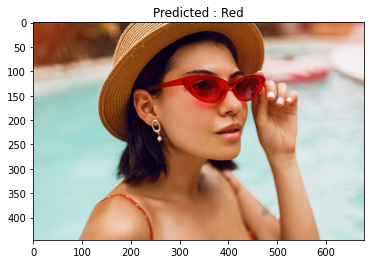

In [66]:
predict_url('https://images.ctfassets.net/u4vv676b8z52/3UeLNSApK8VwWOV1GcAhhg/459f487b56b0d6dd12f421ab2b45672a/red-sunglasses-678x446.gif?fm=jpg&q=80')

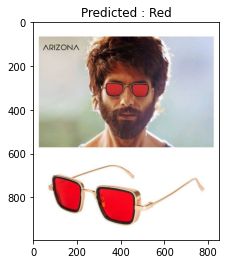

In [67]:
predict_url('https://n4.sdlcdn.com/imgs/j/l/y/Arizona-Sunglasses-Red-Square-Sunglasses-SDL669900666-1-1e2e5.jpg')

#### *Silver Color images*

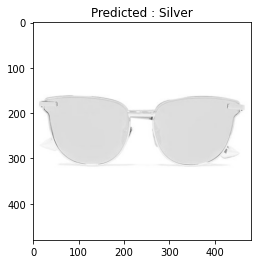

In [68]:
predict_url('https://hips.hearstapps.com/bpc.h-cdn.co/assets/17/12/480x480/square-1489982659-le-specs-pharoah-silver-sunglasses.jpg?resize=480:*')

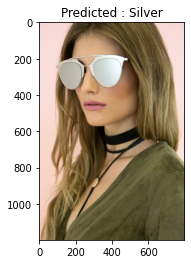

In [69]:
predict_url('https://cdn.shopify.com/s/files/1/0067/2772/products/KK7A1310_1521bf75-a2cc-4546-bafc-92c440a1f6b9_800x.jpg?v=1505296246')

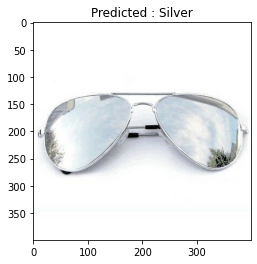

In [70]:
predict_url('https://i.ebayimg.com/images/g/hf0AAOSwo4pYVDJ-/s-l400.jpg')

#### *Yellow Color images*

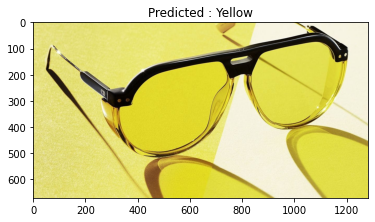

In [71]:
predict_url('https://www.stylist.co.uk/images/app/uploads/2018/08/15155847/styl-613-dior-sunglasses-copy-1282x672.jpg?w=1680&h=880&fit=max&auto=format%2Ccompress')

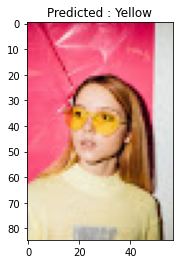

In [72]:
predict_url('https://lh3.googleusercontent.com/fcqlak3wyNabvUqJJicexuiCEFirUZdFdlyqfolMCKGk4vvZ2QrFtIMqjMKRNUOOgu7QDA=s85')

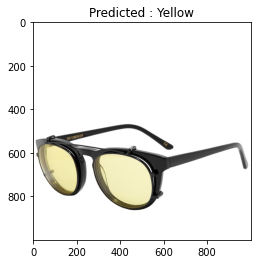

In [73]:
predict_url('https://media.endclothing.com/media/catalog/product/0/4/04-03-2020_han_hantimelessclip-onsunglasses_black_yellow_frame-tl-co-28-sun_jb_1.jpg')

# Summary

The goal of this project was to build a model that would be able to recognize one of the predefined 15 lens colors shown in pictures of glasses as product types.

Going several times through the processes of reprocessing the downloaded dataset, building and testing different convolution models and architectures, using a variety of arguments, optimizers, and augmenters, we came up with the best model that showed the highest accuracy and the best test results with real images, and that is DenseNet169. This model showed an accuracy of 98.4% and hit 42/45 realistic images.

This means that this model will determine, with great precision, the lens color of each pair of glasses shown in any image.